In [1]:
# ============================================================
# Cell 1: Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [2]:
# ============================================================
# Cell 2: Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import json
import random
from pathlib import Path
from PIL import Image, ImageEnhance, ImageFilter
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import timm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [3]:
# ============================================================
# Cell 3: Define Model Architecture Classes
# ============================================================
class SSLEfficientNet(nn.Module):
    """EfficientNet backbone optimized for semi-supervised learning"""
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.5):
        super(SSLEfficientNet, self).__init__()
        
        # Load pretrained backbone
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        # Feature projector for consistency regularization
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        # Classification head with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize additional layers"""
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x, return_features=False):
        """Forward pass with optional feature return"""
        features = self.backbone(x)
        logits = self.classifier(features)
        
        if return_features:
            projected_features = self.projector(features)
            return logits, features, projected_features
        
        return logits
    
    def extract_features(self, x):
        """Extract features without classification"""
        with torch.no_grad():
            features = self.backbone(x)
            return features

class ConsistencyLoss(nn.Module):
    """Consistency loss for semi-supervised learning"""
    def __init__(self, consistency_type='mse', temperature=1.0):
        super(ConsistencyLoss, self).__init__()
        self.consistency_type = consistency_type
        self.temperature = temperature
        
    def forward(self, logits1, logits2):
        if self.consistency_type == 'mse':
            prob1 = F.softmax(logits1 / self.temperature, dim=1)
            prob2 = F.softmax(logits2 / self.temperature, dim=1)
            return F.mse_loss(prob1, prob2)
        elif self.consistency_type == 'kl':
            log_prob1 = F.log_softmax(logits1 / self.temperature, dim=1)
            prob2 = F.softmax(logits2 / self.temperature, dim=1)
            return F.kl_div(log_prob1, prob2, reduction='batchmean')
        else:
            raise ValueError(f"Unknown consistency type: {self.consistency_type}")

class PseudoLabelLoss(nn.Module):
    """Pseudo-labeling loss for semi-supervised learning"""
    def __init__(self, threshold=0.95, temperature=1.0):
        super(PseudoLabelLoss, self).__init__()
        self.threshold = threshold
        self.temperature = temperature
        
    def forward(self, logits, return_mask=False):
        probs = F.softmax(logits / self.temperature, dim=1)
        max_probs, pseudo_labels = torch.max(probs, dim=1)
        
        confidence_mask = max_probs >= self.threshold
        
        if confidence_mask.sum() == 0:
            loss = torch.tensor(0.0, device=logits.device)
        else:
            loss = F.cross_entropy(logits[confidence_mask], pseudo_labels[confidence_mask])
        
        if return_mask:
            return loss, confidence_mask, pseudo_labels
        return loss

def create_ssl_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.5):
    """Create and return SSL model"""
    model = SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)
    return model

def count_parameters(model):
    """Count model parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

print("Model classes defined successfully")

Model classes defined successfully


In [4]:
# ============================================================
# Cell 4: Load Configurations
# ============================================================
ARTIFACTS_DIR = Path("artifacts")

# Load metadata
try:
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    print("Data metadata loaded successfully")
except FileNotFoundError:
    print("ERROR: data_metadata.json not found. Please run 01_data_ingestion.ipynb first!")
    raise

try:
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
        model_config = json.load(f)
    print("Model config loaded successfully")
except FileNotFoundError:
    print("ERROR: model_config.json not found. Please run 02_prepare_base_model.ipynb first!")
    raise

# Training configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
UNLABELED_BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Semi-supervised learning hyperparameters
CONSISTENCY_WEIGHT = 10.0
PSEUDO_LABEL_WEIGHT = 1.0
PSEUDO_THRESHOLD = 0.95
WARMUP_EPOCHS = 10

IMG_SIZE = model_config["model_architecture"]["img_size"]
SEED = 42

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"\nTraining configuration:")
print(f"  Device: {DEVICE}")
print(f"  Batch size (labeled): {BATCH_SIZE}")
print(f"  Batch size (unlabeled): {UNLABELED_BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Consistency weight: {CONSISTENCY_WEIGHT}")
print(f"  Pseudo-label threshold: {PSEUDO_THRESHOLD}")

Data metadata loaded successfully
Model config loaded successfully

Training configuration:
  Device: cpu
  Batch size (labeled): 16
  Batch size (unlabeled): 32
  Epochs: 50
  Learning rate: 0.0001
  Consistency weight: 10.0
  Pseudo-label threshold: 0.95


In [5]:
# ============================================================
# Cell 5: Define Medical Image Augmentation
# ============================================================
class MedicalImageAugmentation:
    """Medical image specific augmentations - Fixed for dtype issues"""
    
    @staticmethod
    def add_medical_artifacts(img, severity=0.3):
        """Add realistic medical imaging artifacts"""
        if random.random() < 0.3:
            img = MedicalImageAugmentation.add_highlights(img, severity)
        if random.random() < 0.2:
            img = MedicalImageAugmentation.add_occlusion(img, severity)
        return img
    
    @staticmethod
    def add_highlights(img, severity=0.3):
        """Add specular highlights (simulating light reflections from moist tissue)"""
        # Convert to float32 to avoid dtype issues
        img_array = np.array(img, dtype=np.float32)
        h, w = img_array.shape[:2]
        
        n_spots = random.randint(1, 2)
        for _ in range(n_spots):
            center_x = random.randint(w//4, 3*w//4)
            center_y = random.randint(h//4, 3*h//4)
            radius = random.randint(10, int(min(h, w) * 0.1))
            intensity = random.uniform(0.5, 1.0) * severity
            
            # Create circular mask
            y, x = np.ogrid[:h, :w]
            mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
            
            # Apply highlight
            if len(img_array.shape) == 3:
                for c in range(3):
                    img_array[mask, c] = np.minimum(
                        img_array[mask, c] * (1 + intensity), 255
                    )
            else:
                img_array[mask] = np.minimum(
                    img_array[mask] * (1 + intensity), 255
                )
        
        # Convert back to uint8
        img_array = np.clip(img_array, 0, 255)
        return Image.fromarray(img_array.astype(np.uint8))
    
    @staticmethod
    def add_occlusion(img, severity=0.3):
        """Add shadow-like occlusions (simulating viewing angle obstructions)"""
        # Convert to float32 to avoid dtype issues
        img_array = np.array(img, dtype=np.float32)
        h, w = img_array.shape[:2]
        
        # Random occlusion parameters
        occ_w = random.randint(w//8, w//4)
        occ_h = random.randint(h//8, h//4)
        occ_x = random.randint(0, w - occ_w)
        occ_y = random.randint(0, h - occ_h)
        darkness = random.uniform(0.3, 0.7) * severity
        
        # Apply occlusion
        if len(img_array.shape) == 3:
            # For RGB images
            img_array[occ_y:occ_y+occ_h, occ_x:occ_x+occ_w] = \
                img_array[occ_y:occ_y+occ_h, occ_x:occ_x+occ_w] * (1 - darkness)
        else:
            # For grayscale images
            img_array[occ_y:occ_y+occ_h, occ_x:occ_x+occ_w] = \
                img_array[occ_y:occ_y+occ_h, occ_x:occ_x+occ_w] * (1 - darkness)
        
        # Ensure values are in valid range and convert back to uint8
        img_array = np.clip(img_array, 0, 255)
        return Image.fromarray(img_array.astype(np.uint8))

print("Medical augmentation class defined successfully")

Medical augmentation class defined successfully


In [6]:
# ============================================================
# Cell 6: Define Data Transforms
# ============================================================
# Strong augmentation for consistency regularization
strong_transform = transforms.Compose([
    transforms.Lambda(lambda x: MedicalImageAugmentation.add_medical_artifacts(x, 0.4)),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Weak augmentation for labeled data and consistency baseline
weak_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined")

Data transforms defined


In [7]:
# ============================================================
# Cell 7: Define Dataset Classes
# ============================================================
class LabeledDataset(Dataset):
    """Dataset for labeled images"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            blank_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            if self.transform:
                blank_img = self.transform(blank_img)
            return blank_img, label, img_path

class UnlabeledDataset(Dataset):
    """Dataset for unlabeled images with dual augmentation"""
    def __init__(self, image_paths, weak_transform, strong_transform):
        self.image_paths = image_paths
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            weak_img = self.weak_transform(image)
            strong_img = self.strong_transform(image)
            return weak_img, strong_img, img_path
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            blank_img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
            weak_img = self.weak_transform(blank_img)
            strong_img = self.strong_transform(blank_img)
            return weak_img, strong_img, img_path

print("Dataset classes defined")

Dataset classes defined


In [8]:
# ============================================================
# Cell 8: Data Loading Functions
# ============================================================
def load_datasets():
    """Load and prepare datasets"""
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir = data_dir / "labeled"
    unlabeled_dir = data_dir / "unlabeled"
    
    # Load labeled data
    labeled_paths, labels = [], []
    class_to_idx = {"Negative": 0, "Positive": 1}
    
    for class_name, class_idx in class_to_idx.items():
        class_dir = labeled_dir / class_name
        if class_dir.exists():
            for img_path in class_dir.glob("*"):
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    labeled_paths.append(str(img_path))
                    labels.append(class_idx)
    
    print(f"Loaded {len(labeled_paths)} labeled images")
    print(f"Class distribution: {Counter(labels)}")
    
    # Split labeled data into train/validation
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
    )
    
    print(f"Training set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    
    # Load unlabeled data
    unlabeled_paths = []
    if unlabeled_dir.exists():
        for img_path in unlabeled_dir.glob("*"):
            if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                unlabeled_paths.append(str(img_path))
    
    print(f"Loaded {len(unlabeled_paths)} unlabeled images")
    
    return (train_paths, train_labels, val_paths, val_labels, unlabeled_paths)

def create_data_loaders(train_paths, train_labels, val_paths, val_labels, unlabeled_paths):
    """Create data loaders"""
    train_dataset = LabeledDataset(train_paths, train_labels, weak_transform)
    val_dataset = LabeledDataset(val_paths, val_labels, val_transform)
    unlabeled_dataset = UnlabeledDataset(unlabeled_paths, weak_transform, strong_transform)
    
    # Adjust num_workers based on system
    num_workers = 0 if DEVICE.type == 'cpu' else 2
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=UNLABELED_BATCH_SIZE, shuffle=True, num_workers=num_workers)
    
    return train_loader, val_loader, unlabeled_loader

print("Data loading functions defined")

Data loading functions defined


In [9]:
# ============================================================
# Cell 9: Define SSL Trainer Class
# ============================================================
class SSLTrainer:
    """Semi-supervised learning trainer"""
    
    def __init__(self, model, train_loader, val_loader, unlabeled_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.unlabeled_loader = unlabeled_loader
        self.device = device
        
        # Loss functions
        self.ce_loss = nn.CrossEntropyLoss()
        self.consistency_loss = ConsistencyLoss('mse')
        self.pseudo_loss = PseudoLabelLoss(threshold=PSEUDO_THRESHOLD)
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=EPOCHS)
        
        # Training history
        self.history = {
            'train_loss': [], 'val_loss': [], 'val_accuracy': [],
            'labeled_loss': [], 'consistency_loss': [], 'pseudo_loss': []
        }
        
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        
        labeled_iter = iter(self.train_loader)
        unlabeled_iter = iter(self.unlabeled_loader) if len(self.unlabeled_loader) > 0 else None
        
        total_loss = 0
        labeled_loss_sum = 0
        consistency_loss_sum = 0
        pseudo_loss_sum = 0
        num_batches = 0
        
        num_iterations = len(self.train_loader)
        
        with tqdm(total=num_iterations, desc=f'Epoch {epoch+1}/{EPOCHS}') as pbar:
            for i in range(num_iterations):
                self.optimizer.zero_grad()
                total_batch_loss = 0
                
                # Process labeled batch
                try:
                    labeled_images, labels, _ = next(labeled_iter)
                except StopIteration:
                    labeled_iter = iter(self.train_loader)
                    labeled_images, labels, _ = next(labeled_iter)
                
                labeled_images, labels = labeled_images.to(self.device), labels.to(self.device)
                
                # Supervised loss on labeled data
                labeled_logits = self.model(labeled_images)
                labeled_loss = self.ce_loss(labeled_logits, labels)
                total_batch_loss += labeled_loss
                labeled_loss_sum += labeled_loss.item()
                
                # Semi-supervised losses (after warmup period)
                if epoch >= WARMUP_EPOCHS and unlabeled_iter is not None:
                    try:
                        weak_images, strong_images, _ = next(unlabeled_iter)
                    except StopIteration:
                        unlabeled_iter = iter(self.unlabeled_loader)
                        weak_images, strong_images, _ = next(unlabeled_iter)
                    
                    weak_images = weak_images.to(self.device)
                    strong_images = strong_images.to(self.device)
                    
                    # Get predictions for consistency loss
                    weak_logits = self.model(weak_images)
                    strong_logits = self.model(strong_images)
                    
                    # Consistency loss
                    consistency_loss = self.consistency_loss(weak_logits, strong_logits)
                    consistency_loss_weighted = CONSISTENCY_WEIGHT * consistency_loss
                    total_batch_loss += consistency_loss_weighted
                    consistency_loss_sum += consistency_loss.item()
                    
                    # Pseudo-label loss
                    pseudo_loss = self.pseudo_loss(weak_logits)
                    pseudo_loss_weighted = PSEUDO_LABEL_WEIGHT * pseudo_loss
                    total_batch_loss += pseudo_loss_weighted
                    pseudo_loss_sum += pseudo_loss.item()
                
                # Backward pass
                total_batch_loss.backward()
                self.optimizer.step()
                
                total_loss += total_batch_loss.item()
                num_batches += 1
                
                pbar.set_postfix({
                    'Loss': f'{total_batch_loss.item():.4f}',
                    'LR': f'{self.optimizer.param_groups[0]["lr"]:.6f}'
                })
                pbar.update(1)
        
        # Calculate average losses
        avg_total_loss = total_loss / num_batches
        avg_labeled_loss = labeled_loss_sum / num_batches
        avg_consistency_loss = consistency_loss_sum / num_batches if epoch >= WARMUP_EPOCHS else 0
        avg_pseudo_loss = pseudo_loss_sum / num_batches if epoch >= WARMUP_EPOCHS else 0
        
        return avg_total_loss, avg_labeled_loss, avg_consistency_loss, avg_pseudo_loss
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.ce_loss(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(self.val_loader)
        val_accuracy = 100 * correct / total
        
        return avg_val_loss, val_accuracy
    
    def train(self):
        """Full training loop"""
        print(f"\nStarting semi-supervised training...")
        print(f"Warmup period: {WARMUP_EPOCHS} epochs")
        
        best_val_accuracy = 0
        patience_counter = 0
        patience = 15
        
        for epoch in range(EPOCHS):
            # Training
            train_loss, labeled_loss, consistency_loss, pseudo_loss = self.train_epoch(epoch)
            
            # Validation
            val_loss, val_accuracy = self.validate()
            
            # Scheduler step
            self.scheduler.step()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            self.history['labeled_loss'].append(labeled_loss)
            self.history['consistency_loss'].append(consistency_loss)
            self.history['pseudo_loss'].append(pseudo_loss)
            
            # Print progress
            ssl_info = ""
            if epoch >= WARMUP_EPOCHS:
                ssl_info = f", Consistency: {consistency_loss:.4f}, Pseudo: {pseudo_loss:.4f}"
            
            print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.2f}%{ssl_info}")
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                patience_counter = 0
                self.save_model(epoch, val_accuracy, 'best')
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
            
            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                self.save_model(epoch, val_accuracy, 'checkpoint')
        
        print(f"\nTraining completed! Best validation accuracy: {best_val_accuracy:.2f}%")
        return self.history
    
    def save_model(self, epoch, val_accuracy, suffix=''):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_accuracy': val_accuracy,
            'history': self.history,
            'config': model_config
        }
        
        filename = f"ssl_model_{suffix}_{epoch+1:03d}_{val_accuracy:.1f}.pth"
        filepath = ARTIFACTS_DIR / filename
        torch.save(checkpoint, filepath)
        print(f"Model saved: {filepath}")

print("SSL Trainer class defined")

SSL Trainer class defined


In [10]:
# ============================================================
# Cell 10: Plotting Functions
# ============================================================
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy curve
    axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # SSL loss components
    axes[1, 0].plot(history['labeled_loss'], label='Labeled Loss')
    axes[1, 0].plot(history['consistency_loss'], label='Consistency Loss')
    axes[1, 0].plot(history['pseudo_loss'], label='Pseudo Loss')
    axes[1, 0].set_title('SSL Loss Components')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Combined view
    ax2 = axes[1, 1]
    ax2_twin = ax2.twinx()
    
    ax2.plot(history['train_loss'], 'b-', label='Train Loss')
    ax2_twin.plot(history['val_accuracy'], 'r-', label='Val Accuracy')
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss', color='b')
    ax2_twin.set_ylabel('Accuracy (%)', color='r')
    ax2.set_title('Loss vs Accuracy')
    ax2.grid(True)
    
    # Add legends
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / "training_history.png", dpi=300, bbox_inches='tight')
    plt.show()

print("Plotting functions defined")

Plotting functions defined


In [11]:
# ============================================================
# Cell 11: Main Training Execution
# ============================================================
def main():
    print("="*60)
    print("SEMI-SUPERVISED LEARNING TRAINING")
    print("="*60)
    
    # Load datasets
    train_paths, train_labels, val_paths, val_labels, unlabeled_paths = load_datasets()
    
    # Create data loaders
    train_loader, val_loader, unlabeled_loader = create_data_loaders(
        train_paths, train_labels, val_paths, val_labels, unlabeled_paths
    )
    
    print(f"\nData loader summary:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Unlabeled batches: {len(unlabeled_loader)}")
    
    # Create model
    model = create_ssl_model(
        num_classes=model_config["model_architecture"]["num_classes"],
        model_name=model_config["model_architecture"]["backbone"],
        dropout_rate=model_config["model_architecture"]["dropout_rate"]
    ).to(DEVICE)
    
    print(f"\nModel summary:")
    total_params, trainable_params = count_parameters(model)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    
    # Create trainer and start training
    trainer = SSLTrainer(model, train_loader, val_loader, unlabeled_loader, DEVICE)
    
    # Train the model
    start_time = time.time()
    history = trainer.train()
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time/60:.1f} minutes")
    
    # Plot training history
    plot_training_history(history)
    
    # Save final history
    with open(ARTIFACTS_DIR / "training_history.json", "w") as f:
        json.dump(history, f, indent=2)
    
    print(f"\nTraining artifacts saved to: {ARTIFACTS_DIR}")
    print("Ready for evaluation with 04_evaluation.ipynb!")
    
    # Generate evaluation files
    print("\nGenerating evaluation files...")
    
    # Load best model for evaluation file generation
    best_models = list(ARTIFACTS_DIR.glob("ssl_model_best_*.pth"))
    if best_models:
        best_model_path = max(best_models, key=lambda x: x.stat().st_mtime)
        checkpoint = torch.load(best_model_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Generate evaluation files
        model.eval()
        all_labels, all_probs = [], []
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(DEVICE)
                logits = model(images)
                probs = F.softmax(logits, dim=1).cpu().numpy()
                
                all_labels.extend(labels.numpy())
                all_probs.extend(probs)
        
        # Save evaluation files
        eval_labels = np.array(all_labels)
        eval_probs = np.array(all_probs)
        
        np.save(ARTIFACTS_DIR / "eval_labels.npy", eval_labels)
        np.save(ARTIFACTS_DIR / "eval_probs.npy", eval_probs)
        
        print(f"Saved evaluation files:")
        print(f"  Labels: {eval_labels.shape}")
        print(f"  Probabilities: {eval_probs.shape}")
        print("Ready for comprehensive evaluation!")
    else:
        print("No trained model found for evaluation file for generation")

SEMI-SUPERVISED LEARNING TRAINING
Loaded 190 labeled images
Class distribution: Counter({1: 98, 0: 92})
Training set: 152 images
Validation set: 38 images
Loaded 6377 unlabeled images

Data loader summary:
  Train batches: 10
  Validation batches: 3
  Unlabeled batches: 200

Model summary:
  Total parameters: 4,705,086
  Trainable parameters: 4,705,086

Starting semi-supervised training...
Warmup period: 10 epochs


Epoch 1/50: 100%|██████████| 10/10 [00:56<00:00,  5.62s/it, Loss=1.0792, LR=0.000100]


Epoch   1/50 | Train Loss: 0.8496, Val Loss: 0.6847, Val Acc: 57.89%
Model saved: artifacts\ssl_model_best_001_57.9.pth


Epoch 2/50: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it, Loss=0.6772, LR=0.000100]


Epoch   2/50 | Train Loss: 0.6399, Val Loss: 0.6854, Val Acc: 63.16%
Model saved: artifacts\ssl_model_best_002_63.2.pth


Epoch 3/50: 100%|██████████| 10/10 [00:48<00:00,  4.82s/it, Loss=0.3996, LR=0.000100]


Epoch   3/50 | Train Loss: 0.5296, Val Loss: 0.6561, Val Acc: 65.79%
Model saved: artifacts\ssl_model_best_003_65.8.pth


Epoch 4/50: 100%|██████████| 10/10 [01:15<00:00,  7.58s/it, Loss=0.4537, LR=0.000099]


Epoch   4/50 | Train Loss: 0.4945, Val Loss: 0.6514, Val Acc: 65.79%


Epoch 5/50: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it, Loss=0.4123, LR=0.000098]


Epoch   5/50 | Train Loss: 0.4113, Val Loss: 0.6295, Val Acc: 73.68%
Model saved: artifacts\ssl_model_best_005_73.7.pth


Epoch 6/50: 100%|██████████| 10/10 [01:39<00:00, 10.00s/it, Loss=0.2079, LR=0.000098]


Epoch   6/50 | Train Loss: 0.3529, Val Loss: 0.6706, Val Acc: 68.42%


Epoch 7/50: 100%|██████████| 10/10 [01:45<00:00, 10.57s/it, Loss=0.3094, LR=0.000096]


Epoch   7/50 | Train Loss: 0.2972, Val Loss: 0.6991, Val Acc: 68.42%


Epoch 8/50: 100%|██████████| 10/10 [01:46<00:00, 10.70s/it, Loss=0.2074, LR=0.000095]


Epoch   8/50 | Train Loss: 0.2605, Val Loss: 0.7001, Val Acc: 71.05%


Epoch 9/50: 100%|██████████| 10/10 [00:41<00:00,  4.19s/it, Loss=0.2917, LR=0.000094]


Epoch   9/50 | Train Loss: 0.2229, Val Loss: 0.7225, Val Acc: 73.68%


Epoch 10/50: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it, Loss=0.4520, LR=0.000092]


Epoch  10/50 | Train Loss: 0.1965, Val Loss: 0.7374, Val Acc: 78.95%
Model saved: artifacts\ssl_model_best_010_78.9.pth
Model saved: artifacts\ssl_model_checkpoint_010_78.9.pth


Epoch 11/50: 100%|██████████| 10/10 [03:10<00:00, 19.04s/it, Loss=1.0328, LR=0.000090]


Epoch  11/50 | Train Loss: 1.1712, Val Loss: 1.3734, Val Acc: 60.53%, Consistency: 0.0953, Pseudo: 0.0314


Epoch 12/50: 100%|██████████| 10/10 [03:11<00:00, 19.16s/it, Loss=1.0072, LR=0.000089]


Epoch  12/50 | Train Loss: 0.9190, Val Loss: 1.7099, Val Acc: 57.89%, Consistency: 0.0680, Pseudo: 0.0242


Epoch 13/50: 100%|██████████| 10/10 [03:02<00:00, 18.24s/it, Loss=0.8212, LR=0.000086]


Epoch  13/50 | Train Loss: 0.7497, Val Loss: 2.0032, Val Acc: 57.89%, Consistency: 0.0533, Pseudo: 0.0188


Epoch 14/50: 100%|██████████| 10/10 [02:58<00:00, 17.85s/it, Loss=0.5740, LR=0.000084]


Epoch  14/50 | Train Loss: 0.6070, Val Loss: 1.9899, Val Acc: 57.89%, Consistency: 0.0399, Pseudo: 0.0173


Epoch 15/50: 100%|██████████| 10/10 [03:05<00:00, 18.52s/it, Loss=0.8482, LR=0.000082]


Epoch  15/50 | Train Loss: 0.5663, Val Loss: 1.9218, Val Acc: 55.26%, Consistency: 0.0357, Pseudo: 0.0138


Epoch 16/50: 100%|██████████| 10/10 [02:56<00:00, 17.69s/it, Loss=0.6388, LR=0.000079]


Epoch  16/50 | Train Loss: 0.5477, Val Loss: 1.6841, Val Acc: 52.63%, Consistency: 0.0351, Pseudo: 0.0151


Epoch 17/50: 100%|██████████| 10/10 [03:05<00:00, 18.52s/it, Loss=0.4692, LR=0.000077]


Epoch  17/50 | Train Loss: 0.5338, Val Loss: 1.5383, Val Acc: 63.16%, Consistency: 0.0356, Pseudo: 0.0155


Epoch 18/50: 100%|██████████| 10/10 [02:58<00:00, 17.86s/it, Loss=1.0437, LR=0.000074]


Epoch  18/50 | Train Loss: 0.5345, Val Loss: 1.6434, Val Acc: 60.53%, Consistency: 0.0335, Pseudo: 0.0164


Epoch 19/50: 100%|██████████| 10/10 [02:58<00:00, 17.85s/it, Loss=0.8392, LR=0.000071]


Epoch  19/50 | Train Loss: 0.5256, Val Loss: 1.6481, Val Acc: 60.53%, Consistency: 0.0299, Pseudo: 0.0148


Epoch 20/50: 100%|██████████| 10/10 [02:59<00:00, 17.98s/it, Loss=0.4240, LR=0.000068]


Epoch  20/50 | Train Loss: 0.3417, Val Loss: 1.4529, Val Acc: 65.79%, Consistency: 0.0214, Pseudo: 0.0122
Model saved: artifacts\ssl_model_checkpoint_020_65.8.pth


Epoch 21/50: 100%|██████████| 10/10 [02:54<00:00, 17.48s/it, Loss=0.1746, LR=0.000065]


Epoch  21/50 | Train Loss: 0.3103, Val Loss: 1.5986, Val Acc: 60.53%, Consistency: 0.0224, Pseudo: 0.0143


Epoch 22/50: 100%|██████████| 10/10 [03:08<00:00, 18.87s/it, Loss=0.5669, LR=0.000062]


Epoch  22/50 | Train Loss: 0.3654, Val Loss: 1.9199, Val Acc: 55.26%, Consistency: 0.0236, Pseudo: 0.0124


Epoch 23/50: 100%|██████████| 10/10 [03:21<00:00, 20.19s/it, Loss=0.1161, LR=0.000059]


Epoch  23/50 | Train Loss: 0.3366, Val Loss: 1.5080, Val Acc: 63.16%, Consistency: 0.0229, Pseudo: 0.0152


Epoch 24/50: 100%|██████████| 10/10 [03:04<00:00, 18.48s/it, Loss=0.2499, LR=0.000056]


Epoch  24/50 | Train Loss: 0.3738, Val Loss: 1.5059, Val Acc: 60.53%, Consistency: 0.0268, Pseudo: 0.0124


Epoch 25/50: 100%|██████████| 10/10 [03:35<00:00, 21.60s/it, Loss=0.5173, LR=0.000053]


Epoch  25/50 | Train Loss: 0.4278, Val Loss: 1.5435, Val Acc: 57.89%, Consistency: 0.0296, Pseudo: 0.0136
Early stopping triggered after 25 epochs

Training completed! Best validation accuracy: 78.95%

Training completed in 59.8 minutes


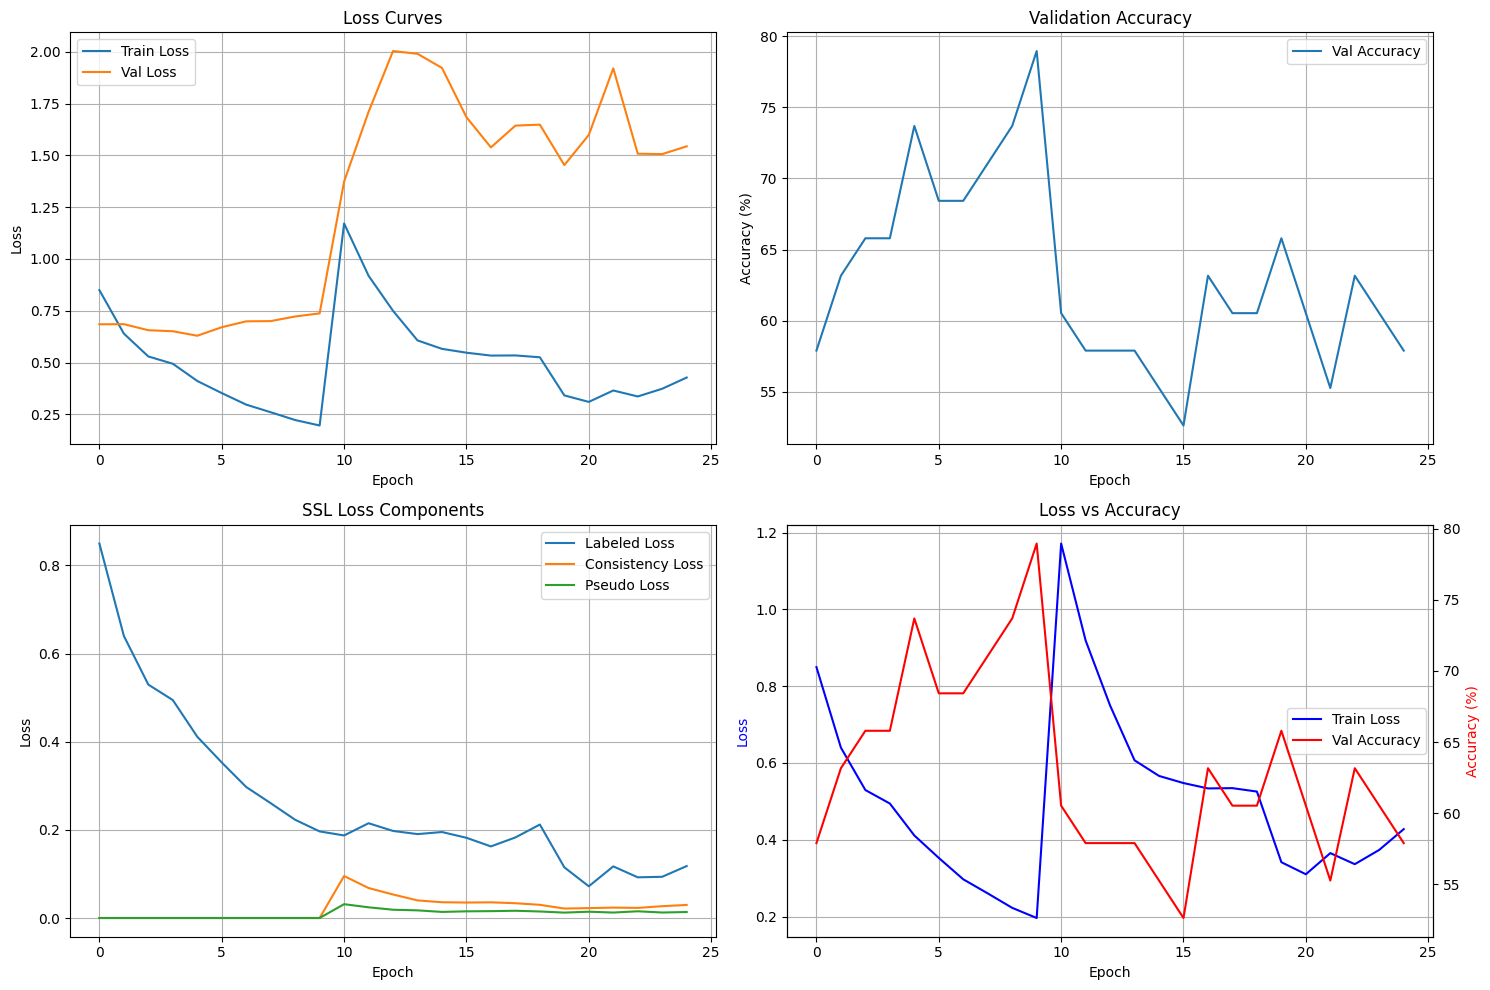


Training artifacts saved to: artifacts
Ready for evaluation with 04_evaluation.ipynb!

Generating evaluation files...
Saved evaluation files:
  Labels: (38,)
  Probabilities: (38, 2)
Ready for comprehensive evaluation!


In [12]:
# ============================================================
# Cell 12: Execute Training (Run this cell to start training)
# ============================================================
if __name__ == "__main__":
    main()